#### Caretaking

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

#### Imports

In [2]:
import os
import math
import re
import nltk

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tqdm import tqdm
from collections import Counter

from fuzzywuzzy import fuzz, process
from itertools import combinations
from statistics import mode

from langdetect import detect, detect_langs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler

from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.metrics import jaccard_distance
from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
import cufflinks as cf
cf.go_offline()

In [59]:
#nltk.download('vader_lexicon')

### Task

Overview: An analysis of the beatles catalogue of songs. Emphasis has been put on the discovering themes and cluster/categorisation.


###### Steps:

- Remove file duplicates from set of 279 and any erroneous files/outliers
- Answer questions pressing questions of the data:
- - How many sons feature the song name in the lyrics?
  - Which song has the largest amount of repetition?
  - Which songs are the most similar?
- Bonus tasks include:
- - Derive a single piece of interesting insight from the data.
  - Classify the songs into topic clusters via machine learning techniques.
  - Group the "new songs" created for this task into the previously created categories.

### Read Data In

In [6]:
lyrics_path = './lyrics/'
new_lyrics_path = './new_lyrics/'

In [7]:
# Get folder contents first of all...
lyrics_ls = [f for f in os.listdir(lyrics_path) if f.endswith('.txt')]
new_lyrics_ls = [f for f in os.listdir(new_lyrics_path) if f.endswith('.txt')]

In [8]:
# ...and then read contents to two different lists.
lyrics = [[file.replace(".txt",""),open(os.path.join(lyrics_path, file), 'r').read()] for file in lyrics_ls]
new_lyrics = [[file.replace(".txt",""),open(os.path.join(new_lyrics_path, file), 'r').read()] for file in new_lyrics_ls]

In [9]:
# Create distinct dataframes and lable as appropriate
combined_lyrics = pd.DataFrame(lyrics,columns=['Song','Lyrics'])
combined_new_lyrics = pd.DataFrame(new_lyrics,columns=['Song','Lyrics'])

combined_lyrics['New/Old'] = "old"
combined_new_lyrics['New/Old'] = "new"

In [10]:
total_lyrics = pd.concat([combined_lyrics,combined_new_lyrics])

### Objective 1: Account for Duplicates and Anomalies

- Account for duplicates in data files:
	- example: "a-day-in-the-life" and "a-day-in-the-life-live-in-amsterdam"
- "weird" or "missing" data.
- Remove anything that looks "amiss"
- Essentially data cleaning

###### Cleansing

In [11]:
def simple_content_check(x):
    
    assess = (x != '\n' and "instrumental" not in x.lower())
    
    return assess

In [12]:
def clean_lyrics(lys):
    
    rgx_pattern = r'[^a-zA-Z0-9\s]'
    
    sentences_ls = lys.split('\n')
    
    std_ls = [re.sub(rgx_pattern,'',x.strip()).lower() for x in sentences_ls if len(x) > 0]
    
    return std_ls

In [13]:
combined_lyrics_adj = total_lyrics[total_lyrics['Lyrics'].apply(simple_content_check)] # adjusted version to exclude based on function above

In [14]:
# Just to check if any adjustments or additions to function above
print(f"{np.round((len(total_lyrics) - len(combined_lyrics_adj))/len(lyrics) * 100,2)} % reduction")

21.86 % reduction


In [15]:
# Drop all duplicate instances on the lyrics column
# Keep first instance by default
combined_lyrics_adj.drop_duplicates(subset=['Lyrics'],inplace=True)

In [16]:
combined_lyrics_adj.reset_index(drop=True,inplace=True)
combined_lyrics_adj.head()

,Song,Lyrics,New/Old
0,a-day-in-the-life-live-in-amsterdam,"I read the news today oh, boy\nAbout a lucky m...",old
1,a-hard-days-night,It's been a hard day's night\nAnd I've been wo...,old
2,a-taste-of-honey,A taste of honey\ntasting much sweeter than wi...,old
3,across-the-universe,Words are flowing out like\nendless rain into ...,old
4,act-naturally,They're gonna put me in the movies\nthey're go...,old


###### Language Differences

In [17]:
# Account for any language differences
combined_lyrics_adj['Languages'] = combined_lyrics_adj['Lyrics'].apply(lambda x: detect(x))

In [18]:
combined_lyrics_adj['Languages'].value_counts()

Languages
en    217
de      2
so      1
Name: count, dtype: int64

In [19]:
# fault of the detection module. Funny one though!
#combined_lyrics_adj.loc[combined_lyrics_adj['Languages'] == 'so']

In [20]:
if "so" in combined_lyrics_adj['Languages'].unique():
    odd_idx = combined_lyrics_adj.loc[combined_lyrics_adj['Languages'] == 'so'].index[0]
    combined_lyrics_adj.drop(index=odd_idx,inplace=True)
#combined_lyrics_adj.loc[combined_lyrics_adj['Languages'] == 'so']

In [21]:
# Two known instances of German versions of Beatles songs being released.
# These pertain to "I Want To Hold Your Hand" and "She Loves You"
# Will omit as the English lang versions of both are already included.
combined_lyrics_adj.loc[combined_lyrics_adj['Languages'] == 'de']

,Song,Lyrics,New/Old,Languages
104,komm-gib-mir-deine-hand,"O komm doch, komm zu mir,\ndu nimmst mir den V...",old,de
165,sie-liebt-dich,Sie liebt dich yeah yeah yeah.\nSie liebt dich...,old,de


In [22]:
combined_lyrics_adj = combined_lyrics_adj.loc[combined_lyrics_adj['Languages'] != 'de']
combined_lyrics_adj.reset_index(drop=True,inplace=True)

###### Cosine Similarity of Song Lyrics

In [23]:
tfidf_vectorizer = TfidfVectorizer()

In [24]:
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_lyrics_adj['Lyrics'])

In [25]:
comparisons_cs = [] # List for cosine similarity
old_df = combined_lyrics_adj.loc[combined_lyrics_adj['New/Old']=="old"]
rng_max = len(old_df)
for i in tqdm(range(rng_max)):
    for j in range(i+1,rng_max): # Avoid self-matching
        
        # Lyrics for each song pairing
        lyrics_i = tfidf_matrix[i]
        lyrics_j = tfidf_matrix[j]
        
        # Compute cosine similarity score
        sim_score = cosine_similarity(lyrics_i,lyrics_j)[0][0]
        
        comparisons_cs.append({
            'Song1': old_df['Song'][i],
            'Song2': old_df['Song'][j],
            'Similarity': sim_score
        })

100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:35<00:00,  6.01it/s]


In [26]:
cosine_similarity_df = pd.DataFrame(comparisons_cs)

In [27]:
# Rationale: the general and short nature of the song "the-end" is causing it to compare...
# ...favourably to many songs. Omitting to inspect further
cosine_similarity_df_redux = cosine_similarity_df[~cosine_similarity_df['Song1'].str.contains('the-end', case=False) & ~cosine_similarity_df['Song2'].str.contains('the-end', case=False)]

In [28]:
# Comfortable to take anything at .7 and above as actually being the same
# And can inspect by eye from here.
# Revolution has a copy with additional lyrics
# Sgt Peppers Lonely Hearts Club Band has a reprise
cosine_similarity_df_redux.sort_values('Similarity',ascending=False).head(5)

,Song1,Song2,Similarity
20286,revolution-1,revolution,0.928954
20826,sgt-peppers-lonely-hearts-club-band-reprise,sgt-peppers-lonely-hearts-club-band,0.869016
12295,hey-jude,run-for-your-life,0.501765
17141,love-me-do,p-s-I-love-you,0.495998
13976,i-want-to-hold-your-hand,you-really-got-a-hold-on-me,0.495958


In [29]:
omit_list = list(cosine_similarity_df_redux.loc[cosine_similarity_df_redux['Similarity']>=0.7]['Song1'].values)
omit_list

['revolution-1', 'sgt-peppers-lonely-hearts-club-band-reprise']

In [30]:
lyrics_clean = combined_lyrics_adj[combined_lyrics_adj['Song'].apply(lambda x: x not in omit_list)]
lyrics_clean.reset_index(drop=True,inplace=True)

## Objective 2: Answer Questions of the Data

Question 1: Which song has the largest amount of repeition?

Question 2: How many of the songs feature the song name (found in the file name) in the song lyrics?

Bonus (from above data cleaning): Which songs are the most similar?

#### Which song has the largest amount of repetition?

- Taking the definition of repetition as "all the unique lines in a song occur more than once".

###### Basic Approach

In [31]:
def repetition_counter(lys):
    
    standardised_ls = clean_lyrics(lys)
    
    standardised_srs = pd.Series(standardised_ls)
    instance_count = standardised_srs.value_counts()
    
    # Terminology may be off here, but count the length of all instances greater than 1
    # Call that number of instances
    # Then the frequency of repetitions in a set of lyrics is the sum of the count of instances
    
    repetition_instances = len(instance_count[instance_count > 1]) # How many lines repeat
    repetition_frequency = instance_count[instance_count > 1].sum() # What is the sum of those repetitions
    
    return [repetition_instances,repetition_frequency]

In [32]:
lyrics_clean['Results'] = lyrics_clean['Lyrics'].apply(repetition_counter)
lyrics_clean[['Repetition Instances','Repetition Frequency']] = lyrics_clean['Results'].apply(pd.Series)
lyrics_clean.drop('Results',axis=1,inplace=True)

###### N-Gram Similarity Approach

In [33]:
def n_gram_sim(lys,jcrd_thresh=1.0):
    
    standardised_ls = clean_lyrics(lys)
    
    # Tokenize lyrics and run calculation
    token_lyrics = [nltk.word_tokenize(x.lower()) for x in standardised_ls]
    n_grams = [list(ngrams(y,2)) for y in token_lyrics]
    
    #return n_grams
    jcrd_similarity = []
    for i in range(len(standardised_ls)):
        for j in range(i + 1, len(standardised_ls)): # Again, avoid self-comparison
            try:
                similarity = 1 - jaccard_distance(set(n_grams[i]), set(n_grams[j]))
                if similarity >= jcrd_thresh: # If they match based on the set threshold then they can be included
                    jcrd_similarity.append([n_grams[i],n_grams[j],similarity])
            except:
                pass

    return len(jcrd_similarity)

In [34]:
lyrics_clean['N_Gram_Similarity'] = lyrics_clean['Lyrics'].apply(n_gram_sim)

In [35]:
# Rankings as seen below. Preliminary check of the top few confirms.
lyrics_clean.sort_values('N_Gram_Similarity',ascending=False)[['Song','N_Gram_Similarity']].head(10)

,Song,N_Gram_Similarity
9,all-together-now,788
83,i-want-you-shes-so-heavy,293
80,i-wanna-be-your-man,200
104,let-it-be,185
170,the-continuing-story-of-bungalow-bill,185
58,good-day-sunshine,136
41,dont-let-me-down,135
39,doctor-robert,126
26,blue-jay-way,105
207,your-mother-should-know,102


#### How many of the songs feature the song name (found in the file name) in the song lyrics?

In [36]:
def song_in_lyrics(row):
    
    clean_song = row['Song'].split('-live')[0].replace("-"," ")
    
    standardised_ls = clean_lyrics(row['Lyrics'])
    
    return clean_song in standardised_ls

In [37]:
lyrics_clean['Name_In_Lyrics'] = lyrics_clean[['Song','Lyrics']].apply(song_in_lyrics, axis=1)
lyrics_clean['Name_In_Lyrics'].value_counts()

Name_In_Lyrics
False    124
True      91
Name: count, dtype: int64

### Objective 3: Derive interesting insight from the data.

- Derived by incorporating third-party data to contextualise the results previously obtained. (https://github.com/inteligentni/Class-05-Feature-engineering/blob/master/The%20Beatles%20songs%20dataset%2C%20v1%2C%20no%20NAs.csv)

In [38]:
beatles_context_data = pd.read_csv('./Context Data/The Beatles songs dataset, v1, no NAs.csv')

In [39]:
# Create a corresponding "Song" column for this df to match the main df.
hyphen_pattern = r'[^\w\s-]'
beatles_context_data['Song'] = beatles_context_data['Title'].apply(lambda x: re.sub(hyphen_pattern,'',x).replace(' ','-').lower())

In [40]:
# Difference list. Of a negligible enough number that I'm happy to continue.
diff_ls = list(set(lyrics_clean['Song'].apply(lambda x: x.lower())) - set(beatles_context_data['Song']))

In [41]:
diff_df = lyrics_clean.loc[~lyrics_clean['Song'].isin(diff_ls)]

In [42]:
diff_df['Song'] = diff_df['Song'].apply(lambda x: x.lower())

In [43]:
context_df = pd.merge(diff_df,beatles_context_data[['Song',
                                                    'Year',
                                                    'Duration',
                                                    'Genre',
                                                    'Songwriter',
                                                    'Lead.vocal',
                                                    'Top.50.Billboard']],on='Song')

In [44]:
# Minor negative correlation (aka, the higher the level of repetition, the higher it was on the charts)
subset_1 = context_df.copy().loc[context_df["Top.50.Billboard"] != -1] # only instances where it came top 50 billboard charts
subset_1['N_Gram_Similarity'].corr(subset_1['Top.50.Billboard']) # simple pearson corr

-0.3686892724389473

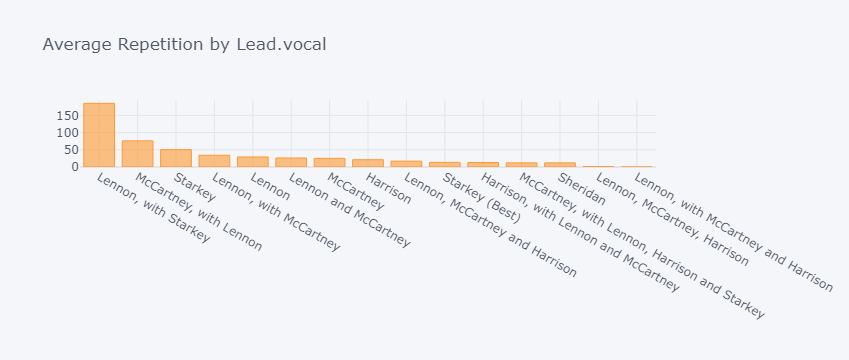

In [45]:
# By injecting context, we can see what the average n_gram_similarity is by lead singer
# With the n_gram_similarity (bigram if we look back at the parameters set when the value was calculated)...
# ... being our measure for repetition.
context_col = "Lead.vocal"
context_df[[context_col,'N_Gram_Similarity']].groupby(context_col).mean()[['N_Gram_Similarity']].sort_values('N_Gram_Similarity',ascending=False).iplot(kind='bar',title=f"Average Repetition by {context_col}")

In [46]:
def calculate_mode(column):
    try:
        return mode(column)
    except StatisticsError:
        return None

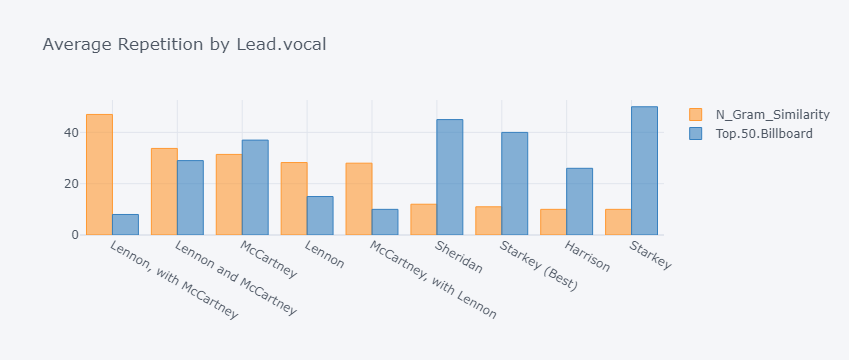

In [47]:
# Same as above, but only looking at instances where they made it to the billboard top 50
# Features average chart position.

aggregations = {
    'N_Gram_Similarity': 'mean',  # Sum of column A
    'Top.50.Billboard': calculate_mode,  # Mean of column B
}

context_col = "Lead.vocal"
subset_1[[context_col,'N_Gram_Similarity','Top.50.Billboard']].groupby(context_col).agg(aggregations)[['N_Gram_Similarity',"Top.50.Billboard"]].sort_values('N_Gram_Similarity',ascending=False).iplot(kind='bar',title=f"Average Repetition by {context_col}")

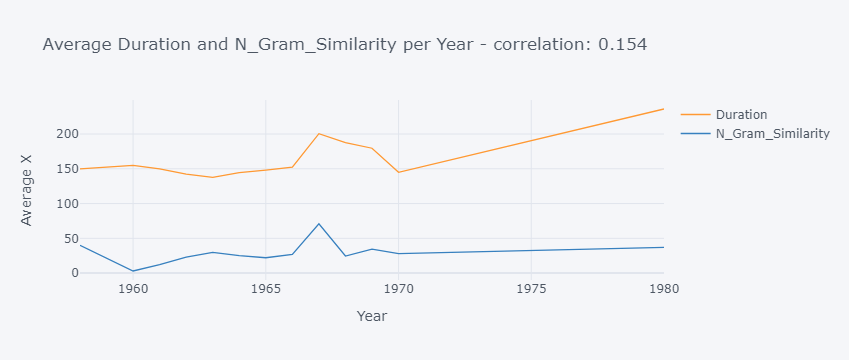

In [48]:
col_a = "Duration"
col_b = "N_Gram_Similarity"
correlation = context_df[col_a].corr(context_df[col_b])
context_df[['Year','Duration','N_Gram_Similarity']].groupby('Year').mean().iplot(title=f'Average {col_a} and {col_b} per Year - correlation: {np.round(correlation,3)}',
                                                                                 xTitle='Year',
                                                                                 yTitle='Average X')

### Objective 4&5: Put Songs into Clusters / Categories

###### Sentiment Analysis of Topics and Clusters

In [49]:
sia = SentimentIntensityAnalyzer() # Init SIA

In [50]:
def compound_assignment(score):
    # Custom sentiment categories and threshold ranges
    # Covering regular intervals from 1 to -1
    sentiment_categories = {
        "Strongly Positive": (0.5, 1.0),
        "Moderately Positive": (0.2, 0.5),
        "Slightly Positive": (0.05, 0.2),
        "Neutral": (-0.05, 0.05),
        "Slightly Negative": (-0.2, -0.05),
        "Moderately Negative": (-0.5, -0.2),
        "Strongly Negative": (-1.0, -0.5),
    }

    # Sentiment category based on the custom thresholds
    for category, (lower_threshold, upper_threshold) in sentiment_categories.items():
        if lower_threshold <= score <= upper_threshold:
            return category
    
    return "Undefined"  # Default category if the score is outside of defined thresholds

In [51]:
lyrics_clean['Compound Sentiment Score'] = lyrics_clean['Lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])
lyrics_clean['Compound Sentiment Assignment'] = lyrics_clean['Compound Sentiment Score'].apply(lambda x: compound_assignment(x))

In [52]:
tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_clean['Lyrics'])

In [53]:
feature_cols = ['Lyrics','N_Gram_Similarity', 
                'Compound Sentiment Score',
                "Repetition Instances", 
                "Repetition Frequency"]

In [54]:
feature_df = lyrics_clean[feature_cols]

In [55]:
lyrics_tfidf = tfidf_vectorizer.fit_transform(feature_df['Lyrics'])

In [56]:
lyrics_tfidf_df = pd.DataFrame(lyrics_tfidf.toarray(),
                               columns=tfidf_vectorizer.get_feature_names_out())

In [57]:
feature_matrix = pd.concat([lyrics_tfidf_df,feature_df.drop('Lyrics',axis=1)],axis=1)

In [58]:
# Using Elbow Method
range_upper_bound = int(len(lyrics_clean['Lyrics'].unique())/4) 
range_n_clusters = list(range(1,range_upper_bound))

sum_squares = []
for n_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(feature_matrix)
    sum_squares.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:43<00:00,  1.99s/it]


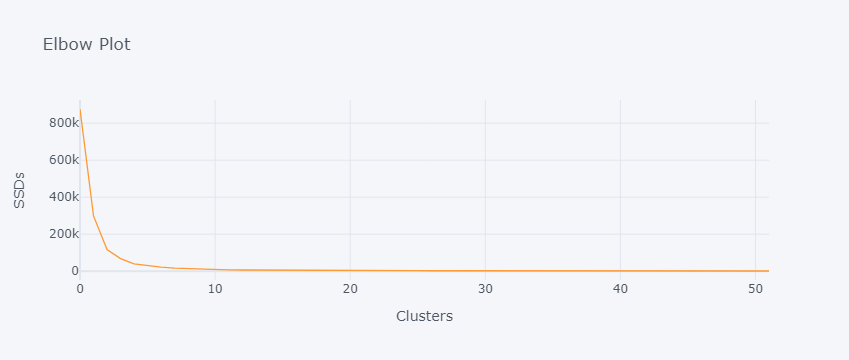

In [60]:
pd.Series(sum_squares).iplot(title='Elbow Plot',
                             xTitle='Clusters',
                             yTitle='SSDs') # I call it about 4?

##### Kneedle Locate value of K
- Why eyeball it when there is a statistical method!

In [61]:
elbow_df = pd.DataFrame(sum_squares)

In [62]:
kneedle = KneeLocator(elbow_df.index[1:],elbow_df[0][1:], curve="convex", direction="decreasing")

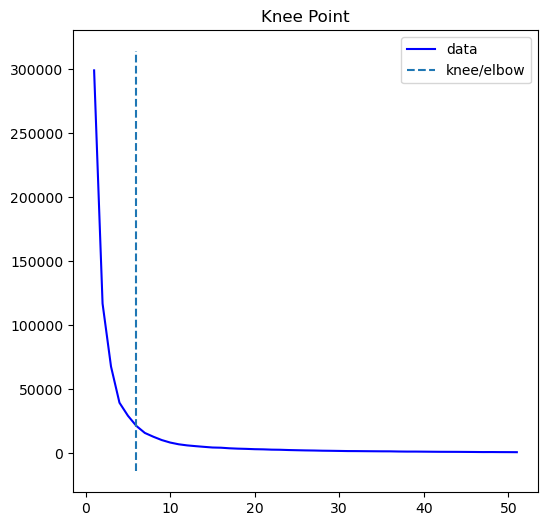

In [63]:
kneedle.plot_knee()

In [64]:
kneedle.knee

6

In [65]:
optimal_cluster_num = kneedle.knee

In [66]:
kmeans = KMeans(n_clusters=optimal_cluster_num, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(feature_matrix)

In [67]:
pd.Series(cluster_labels).value_counts()

0    105
3     87
5     15
2      6
1      1
4      1
Name: count, dtype: int64

In [68]:
lyrics_clean['Cluster Labels'] = pd.Series(cluster_labels)

In [70]:
# Clustering on JUST Lyrics

lyrics_clean_matrix = tfidf_vectorizer.fit_transform(lyrics_clean['Lyrics'])

kmeans = KMeans(n_clusters=optimal_cluster_num, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(lyrics_clean_matrix)

lyrics_clean['Cluster Labels LYRICS_ONLY'] = pd.Series(cluster_labels)

### Meaning

In [71]:
def preprocess_txt(text):
    
    # Tokenize input text
    tokens = nltk.word_tokenize(text)
    
    # Clean and lower case it all
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

In [72]:
grouped_lyrs = lyrics_clean.groupby('Cluster Labels LYRICS_ONLY')
theme_ls = []
top_x = 20
for cluster_label, group in grouped_lyrs:
    
    # Prepare corpus of words
    all_lyrics = " ".join(group['Lyrics'])
    preprocessed_lyrics = preprocess_txt(all_lyrics)
    
    # Calc the word frequencies
    word_frequencies = Counter(preprocessed_lyrics)
    
    # Get just the top 10
    common_words = word_frequencies.most_common(top_x)
    
    # make dataframe output
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    
    # Add a new column for the cluster label
    common_words_df['Cluster Label'] = cluster_label
    
    # Add the DataFrame to the list
    theme_ls.append(common_words_df)